In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd

In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks'

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Bitcoin Dataset.zip'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [ ]:
ds = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
ds.head()

In [ ]:
#ds = pd.read_csv("/content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
#ds.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ds['Timestamp'] = pd.to_datetime(ds['Timestamp'],unit='s')
ds = ds.set_index('Timestamp')
ds['Price'] = (ds['High']+ ds['Low'])/2
ds.head()


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price
Timestamp,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ds = ds.resample('6H').mean()
ds = ds.dropna()
ds.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price
Timestamp,,,,,,,,
2011-12-31 06:00:00,4.39,4.390000,4.39,4.390000,0.455581,2.000000,4.390000,4.390000
2011-12-31 12:00:00,4.49,4.513333,4.49,4.513333,31.620766,141.106779,4.498804,4.501667
2012-01-01 00:00:00,4.58,4.580000,4.58,4.580000,1.502000,6.879160,4.580000,4.580000
2012-01-01 12:00:00,4.84,4.840000,4.84,4.840000,10.000000,48.400000,4.840000,4.840000
2012-01-01 18:00:00,5.00,5.000000,5.00,5.000000,10.100000,50.500000,5.000000,5.000000


In [ ]:
forecast_out = 500
train= ds['Price'][:len(ds['Price'])-forecast_out].values.reshape(-1,1)
test= ds['Price'][len(ds['Price'])-forecast_out:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(test)

In [ ]:
def create_dataset(dataset, look_back=30):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(scaled_train)
x_test, y_test = create_dataset(scaled_test)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [ ]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 97 kB 4.4 MB/s 


In [ ]:
import keras_tuner as kt

def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= ( x_train.shape[1], x_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    
    return model
    


In [ ]:
tuner = kt.RandomSearch(model_builder, objective="mse", max_trials = 3, executions_per_trial =1,directory = "./")

tuner.search(x_train, y=y_train, epochs = 160, batch_size =128, validation_data=(x_test, y_test), shuffle=False)

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
input_unit: 160
n_layers: 4
lstm_0_units: 448
layer_2_neurons: 480
Dropout_rate: 0.05
dense_activation: sigmoid
lstm_1_units: 32
lstm_2_units: 32
lstm_3_units: 32
Score: 0.048442158848047256
Trial summary
Hyperparameters:
input_unit: 512
n_layers: 3
lstm_0_units: 512
layer_2_neurons: 160
Dropout_rate: 0.25
dense_activation: relu
lstm_1_units: 288
lstm_2_units: 512
lstm_3_units: 256
Score: 0.07578345388174057


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
history = best_model.fit(x=x_train, y=y_train, epochs = 150, batch_size =128, validation_data=(x_test, y_test), shuffle=False, verbose=0)

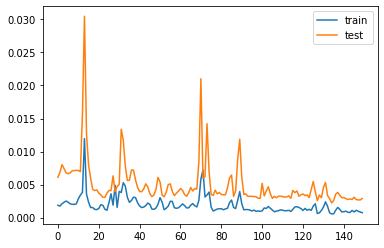

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
predicted_price = best_model.predict(x_test)

In [ ]:
predicted_price = scaler_test.inverse_transform(predicted_price.reshape(-1, 1))

In [ ]:
true = scaler_test.inverse_transform(y_test.reshape(-1, 1))

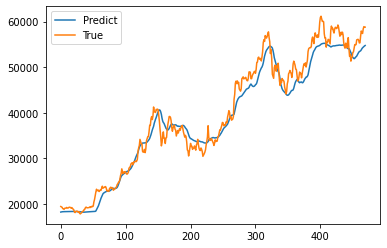

In [ ]:
plt.plot(predicted_price, label='Predict')
plt.plot(true, label='True')
plt.legend()
plt.show()